In [1]:
import os, sys
import warnings

warnings.filterwarnings("ignore")

parent_dir = os.path.abspath(os.getcwd())

# 遍历所有子目录并将它们添加到sys.path中
for dirpath, dirnames, filenames in os.walk(parent_dir):
    for dirname in dirnames:
        sys.path.append(os.path.abspath(os.path.join(dirpath, dirname)))


import time
from ipywebrtc import AudioRecorder, CameraStream
from ipywidgets import Output, GridspecLayout
from IPython.display import display, Audio, Javascript, clear_output
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib as mpl
from voice_conversion.Utils.JDC.model import JDCNet
from voice_conversion.Models.models import Generator, MappingNetwork, StyleEncoder
from munch import Munch
from parallel_wavegan.utils import load_model
import torch
import torchaudio
import yaml
import noisereduce as nr
import librosa
import numpy as np


sns.set_theme()

## Setup

In [2]:
%config InlineBackend.figure_format = 'retina'
sr = 24000

F = 'female'
M = 'male'
device = 'cpu'

#speaker related
speaker_file = "dataset/Data/train_list.txt"
speakers_num = 20
pseudo_names = {11: 'Joe', 12: 'Mark', 13: 'Tony', 14: 'Tom', 15: 'Anna', 16: 'Jane', 17: 'Mary', 18: 'Julia', 19: 'Lizy', 20: 'Harry'}
gender_map = {11: M, 12: M, 13: M, 14: M, 15: F, 16: F, 17: F, 18: F, 19: F, 20: M}
selected_speakers = [15, 13, 16, 14, 17, 19]

# models' paths
f0_path = 'voice_conversion/Utils/JDC/bst.t7'
vocoder_path = 'voice_conversion/Utils/vocoder/checkpoint-2500000steps.pkl'
stargan_config_dir = 'voice_conversion/Configs/'
stargan_pth_dir = "checkpoints/"
stargan_model_name = 'emo_stargan_pretrained.pth'

## Utility Methods

In [3]:
def get_spkr_name(fname):
    fnm_arr = file_name.split('/')
    if 'ESD' in fname:
        name = fnm_arr[-1]
        name = name.split('_')
        name = name[0].replace('00', '')
    else:
        name = fnm_arr[-2]
    return name


# Get a speaker dict from config
speakers_20 = np.zeros((speakers_num), dtype=int)
with open(speaker_file) as file:
    lines = file.readlines()

speaker_dicts_20 = {}

for line in lines:
    file_name, sp_id = line.split('|')
    sp_id = int(sp_id)
    spkr_nm = get_spkr_name(file_name)
    speaker_dicts_20[spkr_nm] = sp_id
    speakers_20[sp_id] = int(spkr_nm.replace('p', ''))
speakers_20 = speakers_20.tolist()

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4


class DefaultDict(dict):
    """Implementation of perl's autovivification feature."""

    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value


def compute_style(starganv2, slct_spkrs, speaker_dicts):
    '''get speaker embeddings'''
    reference_embeddings = DefaultDict()
    for sp in slct_spkrs:
        key = str(sp)
        speaker = int(speaker_dicts[key])
        label = torch.LongTensor([speaker]).to(device)
        latent_dim = starganv2.mapping_network.shared[0].in_features
        ref = starganv2.mapping_network(
            torch.randn(1, latent_dim).to(device), label)
        reference_embeddings[key] = (ref, label)

    return reference_embeddings


def build_inference_pipeline(device='cuda'):

    def build_model(model_params):
        args = Munch(model_params)
        generator = Generator(args.dim_in, args.style_dim, args.max_conv_dim,
                              w_hpf=args.w_hpf, F0_channel=args.F0_channel)

        # Can use both to generate embeddings...
        mapping_network = MappingNetwork(
            args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim)
        style_encoder = StyleEncoder(
            args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)

        nets_ema = Munch(generator=generator,
                         mapping_network=mapping_network,
                         style_encoder=style_encoder)

        return nets_ema

    # load F0 model
    F0_model = JDCNet(num_class=1, seq_len=192)
    params = torch.load(f0_path, map_location=device)['net']
    F0_model.load_state_dict(params)
    _ = F0_model.eval()
    F0_model = F0_model.to(device)

    # load hifigan vocoder
    vocoder = load_model(vocoder_path).to(device).eval()
    vocoder.remove_weight_norm()
    _ = vocoder.eval()

    # load emo-stargan model
    with open(os.path.join(stargan_config_dir, 'config.yml')) as f:
        emostargan_config = yaml.safe_load(f)

    emostargan = build_model(model_params=emostargan_config["model_params"])
    params = torch.load(os.path.join(
        stargan_pth_dir, stargan_model_name), map_location=device)
    params = params['model_ema']
    _ = [emostargan[key].load_state_dict(
        params[key], strict=False) for key in emostargan]
    _ = [emostargan[key].eval() for key in emostargan]
    emostargan.style_encoder = emostargan.style_encoder.to(device)
    emostargan.mapping_network = emostargan.mapping_network.to(device)
    emostargan.generator = emostargan.generator.to(device)

    # initialise speaker details from config file
    reference_embeddings = compute_style(
        emostargan, selected_speakers, speaker_dicts_20)

    return emostargan, F0_model, vocoder, reference_embeddings


# Little utils
def get_F0(wav):
    f0, _, _ = librosa.pyin(wav, fmin=librosa.note_to_hz(
        'C2'), fmax=librosa.note_to_hz('C7'))
    return f0


def get_melspec(wav):
    return librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)


def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor


def generate_conversions(wav, starganv2, reference_embeddings, F0_model, vocoder, noise_reduce=False):
    '''
    generate conversion for the selected speakers, whose speaker embeddings were generated
    Args:
        wav:
        starganv2:
        reference_embeddings:
        F0_model:
        vocoder:
        noise_reduce:

    Returns:

    '''
    source = preprocess(wav)
    t = []
    keys = []
    reconstructed_samples = DefaultDict()
   # print('Target Speakers:')
    for key, (ref, _) in reference_embeddings.items():
        print(pseudo_names[int(key.replace('p', ''))])
        # start = time.time()
        with torch.no_grad():
            f0_feat = F0_model.get_feature_GAN(source.unsqueeze(1))
            out = starganv2.generator(source.unsqueeze(1), ref, F0=f0_feat)
            c = out.transpose(-1, -2).squeeze()
            if key not in speaker_dicts_20 or speaker_dicts_20[key] == "":
                recon = None
                print(key, 'not in speaker_dicts')
            else:
                recon = vocoder.inference(c)
                recon = recon.view(-1).cpu().numpy()
                recon = recon / np.max(np.abs(recon))
        # end = time.time()
        # t.append(end - start)

        reconstructed_samples[key] = recon
        keys.append(key)
        if noise_reduce:
            recon = nr.reduce_noise(y=recon, sr=sr, prop_decrease=0.5)
        display(Audio(recon, rate=sr))

    # print('Average processing time per speaker: %.3f sec' % (sum(t) / len(t)))
    return keys, reconstructed_samples


def self_convert(wav, vocoder):
    '''convert an audio to mel-spectrogam, and then fed to vocoder to generate the audio. This is needed, so that
    its possible to plot the original recording with the converted ones, as theres always some mismatch between original
    and vocoder generated samples.'''
    mel = preprocess(wav)
    c = mel.transpose(-1, -2).squeeze()
    with torch.no_grad():
        recon_hifi = vocoder.inference(c)
        recon_hifi = recon_hifi.view(-1).cpu().numpy()
    return recon_hifi


def plot_melspec(keys, audios, sample_rate=24000, noise_reduce=False):
    ''' displays the converted mel-spectrograms'''

    fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    plt.subplots_adjust(bottom=0.1, hspace=0.3)
    idx = 0
    idy = 0
    f0s = []
    for key in keys:
        audio_ = audios[key]
        gender = gender_map[int(key)]
        if noise_reduce:
            audio_ = nr.reduce_noise(
                y=audio_, sr=sample_rate, prop_decrease=0.5)
        librosa.display.specshow(get_melspec(audio_),
                                 x_axis='time',
                                 y_axis='log',
                                 edgecolors='None',
                                 ax=axs[idx, idy])
        f0 = get_F0(audio_)
        f0s.append(f0)
        times = librosa.times_like(f0)
        axs[idx, idy].plot(times, f0, label='f0', color='cyan', linewidth=2)
        axs[idx, idy].set_title(pseudo_names[int(key)],
                                color='lightcoral' if gender == F else 'green')

        if idy == 2:
            idx += 1
            idy = 0
        else:
            idy += 1
    plt.show()
    return f0s


def get_gender_legend():
    ''' generate the gender specific legends '''
    f_l = mlines.Line2D([], [], color='lightcoral', marker='s', ls='', label=F)
    m_l = mlines.Line2D([], [], color='green', marker='s', ls='', label=M)
    plt.legend(handles=[f_l, m_l])


def get_intensity(audio_):
    return librosa.feature.rms(y=audio_, frame_length=150, hop_length=300, center=True)[0]


def get_trimmed(self_measure, conv_measure):
    if conv_measure.shape > self_measure.shape:
        diff = conv_measure.shape[0] - self_measure.shape[0]
        conv_measure = conv_measure[:-diff]
    elif conv_measure.shape < self_measure.shape:
        diff = self_measure.shape[0] - conv_measure.shape[0]
        self_measure = self_measure[:-diff]
    return self_measure, conv_measure


def get_F0s_for_plots(wav_nr, vocoder, target_speakers, t_f0s):

    colours = []
    labels = []
    f0s = []
    vocoder_generated = self_convert(wav_nr, vocoder=vocoder)
    self_f0 = get_F0(vocoder_generated)

    first_flag = True

    for (key, f0) in zip(target_speakers, t_f0s):
        self_f0, f0 = get_trimmed(self_f0, f0)

        if first_flag:
            times = librosa.times_like(f0)
            f0s.append(self_f0)
            colours.append('black')
            labels.append('Self')
            first_flag = False

        f0s.append(f0)
        colours.append('lightcoral' if gender_map[int(
            key.replace('p', ''))] == F else 'green')
        labels.append(pseudo_names[int(key)])

    return f0s, colours, labels, times


def get_rmse_for_plots(wav_nr, vocoder, target_speakers, converted_samples):
    '''

    Args:
        wav_nr:
        vocoder:
        target_speakers:
        converted_samples:

    Returns:

    '''
    intnsts = []
    colours = []
    labels = []
    vocoder_generated = self_convert(wav_nr, vocoder=vocoder)
    self_intnsty = get_intensity(vocoder_generated)
    first_flag = False
    for key in target_speakers:
        audio_ = converted_samples[key]

        intnsty = get_intensity(audio_)
        self_intnsty, intnsty = get_trimmed(self_intnsty, intnsty)

        if not first_flag:
            times = librosa.times_like(intnsty)
            intnsts.append(self_intnsty)
            colours.append('black')
            labels.append('Self')
            first_flag = True

        intnsts.append(intnsty)
        colours.append('lightcoral' if gender_map[int(
            key.replace('p', ''))] == F else 'green')
        labels.append(pseudo_names[int(key)])
    return intnsts, colours, labels, times


def get_F0s(wav_nr, vocoder, target_speakers, converted_samples):
    f0s = []
    colours = []
    labels = []
    vocoder_generated = self_convert(wav_nr, vocoder=vocoder)
    self_f0 = get_F0(vocoder_generated)
    first_flag = True
    for key in target_speakers:
        audio_ = converted_samples[key]

        f0 = get_F0(audio_)
        self_f0, f0 = get_trimmed(self_f0, f0)

        if first_flag:
            times = librosa.times_like(f0)

            f0s.append(self_f0)
            colours.append('black')
            labels.append('self')
            first_flag = False

        f0s.append(f0)
        colours.append('lightcoral' if gender_map[int(
            key.replace('p', ''))] == F else 'green')
        labels.append(pseudo_names[int(key)])
    return f0s, colours, labels, times


def get_recording(recorder):

    with open('recording.wav', 'wb') as f:
        f.write(recorder.audio.value)
    #!ffmpeg -i recording.wav -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
    audio_np, orig_sr = librosa.load('recording.wav')
    audio = audio_np / np.max(np.abs(audio_np))
    wav = librosa.resample(audio, orig_sr=orig_sr, target_sr=24000)

    # wav_nr = nr.reduce_noise(y=wav, sr=24000, n_std_thresh_stationary=2,stationary=True, prop_decrease=0.9)
    wav_nr = nr.reduce_noise(
        y=wav, sr=24000, thresh_n_mult_nonstationary=1.5, stationary=False, prop_decrease=0.7)

    return wav/np.max(np.abs(wav)), wav_nr/np.max(np.abs(wav_nr))

In [4]:
# camera = CameraStream(constraints={"audio": True, "video": False})
# recorder = AudioRecorder(stream=camera)
# recorder

In [5]:
# wav, wav_nr = get_recording(recorder)
# print("The noise-filtered recording...")
# display(Audio(wav_nr, rate=sr, autoplay=False))
# print("The original recording...")
# display(Audio(wav, rate=sr, autoplay=False))

In [6]:
from ipywebrtc import AudioStream

audio_np, orig_sr = librosa.load('test_audio.mp3')
audio = audio_np / np.max(np.abs(audio_np))
wav = librosa.resample(audio, orig_sr=orig_sr, target_sr=24000)

# wav_nr = nr.reduce_noise(y=wav, sr=24000, n_std_thresh_stationary=2,stationary=True, prop_decrease=0.9)
wav_nr = nr.reduce_noise(
    y=wav, sr=24000, thresh_n_mult_nonstationary=1.5, stationary=False, prop_decrease=0.7)

wav, wav_nr =wav/np.max(np.abs(wav)), wav_nr/np.max(np.abs(wav_nr))

In [7]:
print("The noise-filtered recording...")
display(Audio(wav_nr, rate=sr, autoplay=False))
print("The original recording...")
display(Audio(wav, rate=sr, autoplay=False))

The noise-filtered recording...


The original recording...


## It looks like ...

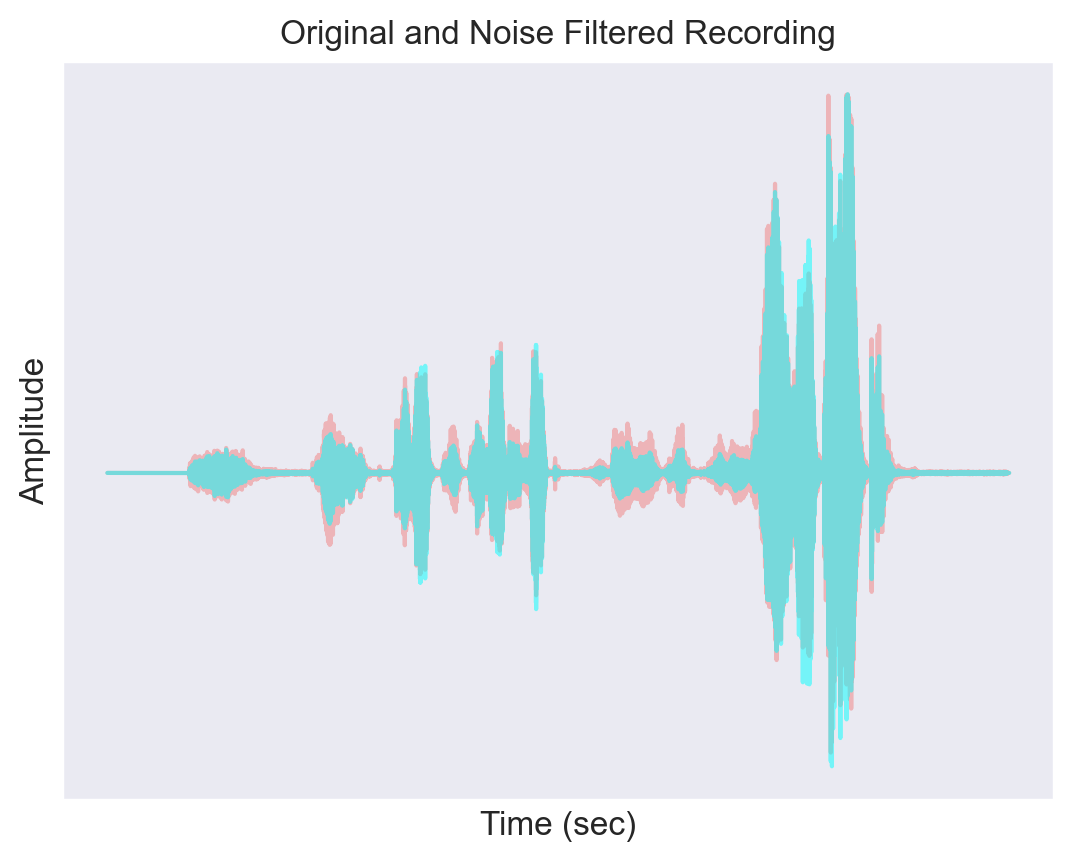

In [8]:
# plot wave
time = np.round(wav_nr.shape[0] / sr)
plt.plot(wav, alpha=0.5, color="lightcoral")
plt.plot(wav_nr, alpha=0.5, color="cyan")
plt.xticks([])
plt.yticks([])
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Original and Noise Filtered Recording")
plt.show()

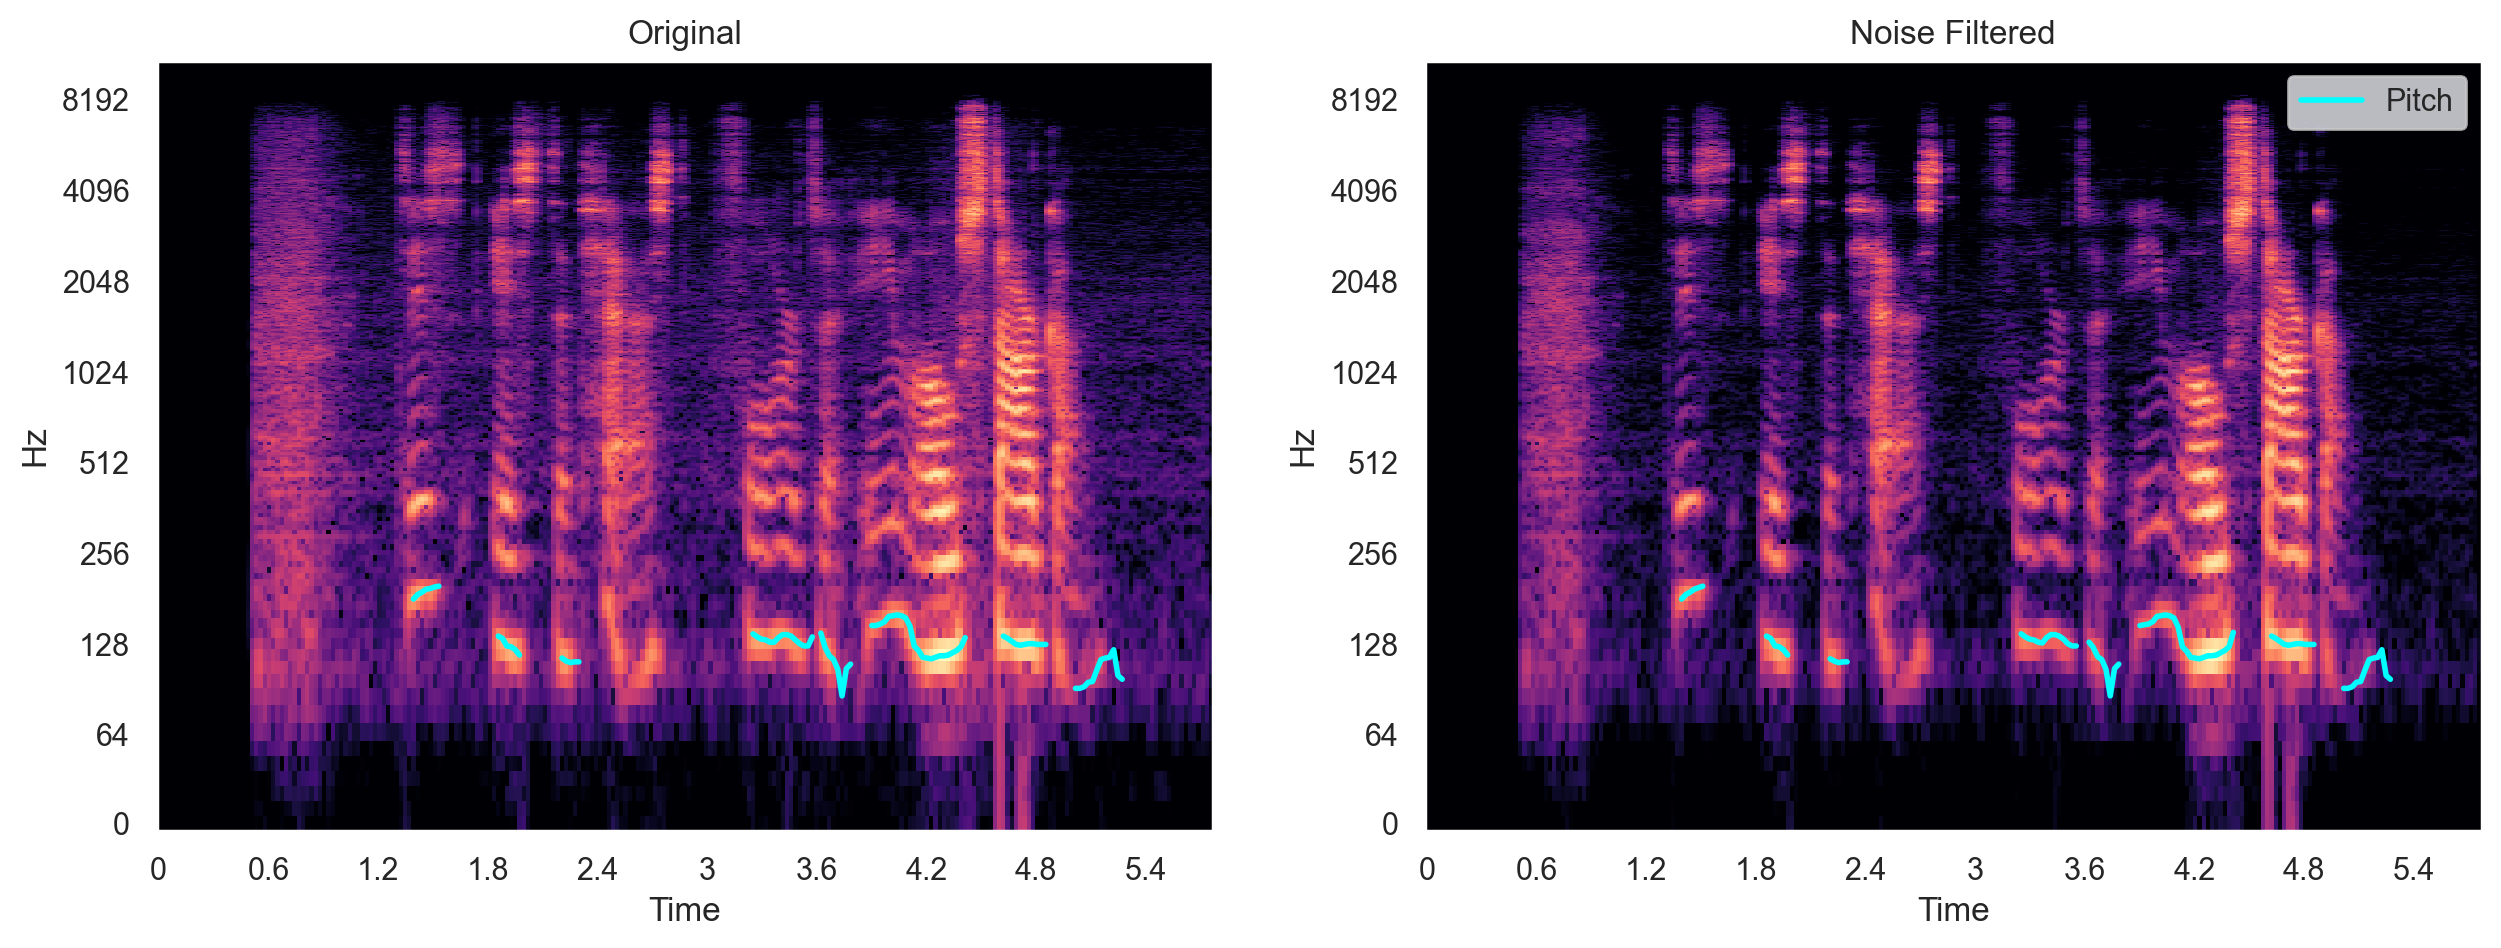

In [9]:
# plot mel-spectrogram along with F0

import librosa.display


f0 = get_F0(wav)

f0_nr = get_F0(wav_nr)

D_orig = get_melspec(wav)

D_filt = get_melspec(wav_nr)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

librosa.display.specshow(D_orig, x_axis="time", y_axis="log", ax=ax1)

librosa.display.specshow(D_filt, x_axis="time", y_axis="log", ax=ax2)


times = librosa.times_like(f0)


ax1.plot(times, f0, label="f0", color="cyan", linewidth=2)

ax1.title.set_text("Original")

ax2.plot(times, f0_nr, label="Pitch", color="cyan", linewidth=2)

ax2.title.set_text("Noise Filtered")

ax2.legend(loc="upper right")
plt.show()

## Let's Listen to the Conversions!

In [10]:
emostargan, F0_model, vocoder, reference_embeddings = build_inference_pipeline(
    device='cpu')

print('Using noise-filtered recording:\n------------------------------------')

target_speakers, converted_samples = generate_conversions(wav_nr,

                                                          emostargan,

                                                          reference_embeddings,

                                                          F0_model,

                                                          vocoder,

                                                          noise_reduce=False)

Using noise-filtered recording:
------------------------------------
Anna


Tony


Jane


Tom


Mary


Lizy


In [11]:
print("Using original recording:\n------------------------------------")
target_speakers, converted_samples = generate_conversions(
    wav, emostargan, reference_embeddings, F0_model, vocoder, noise_reduce=True
)

Using original recording:
------------------------------------
Anna


Tony


Jane


Tom


Mary


Lizy


## More Insights...


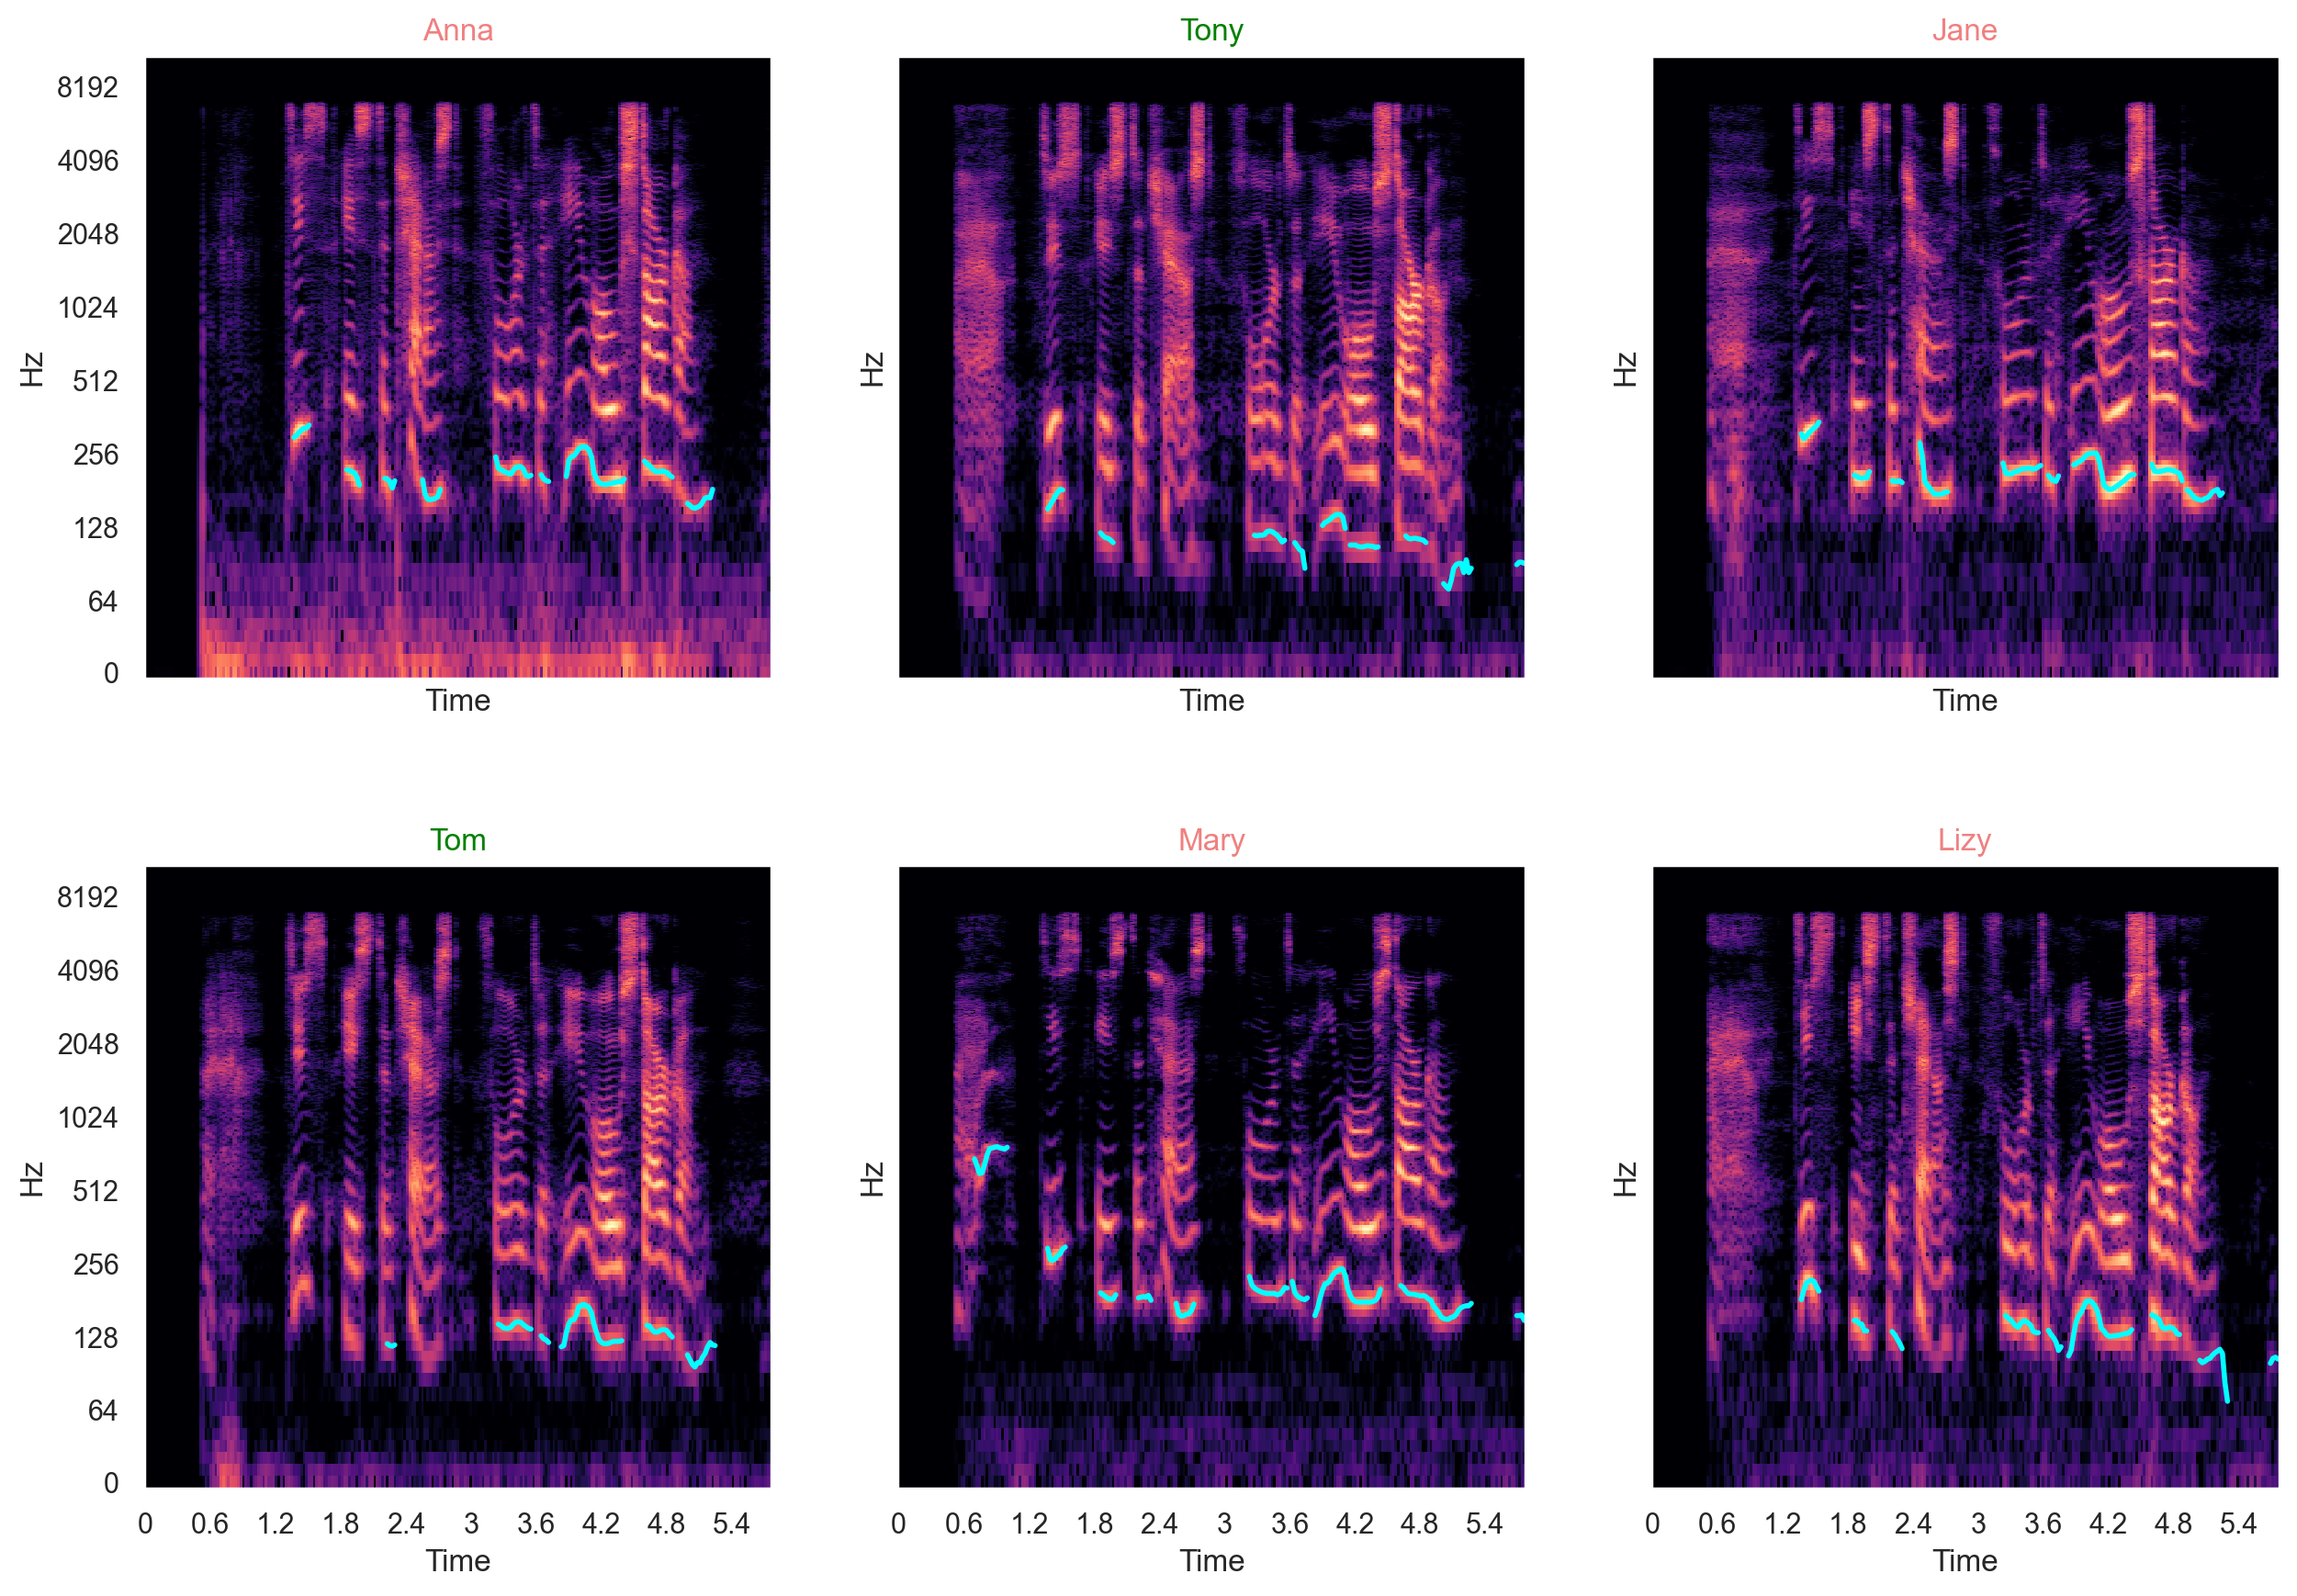

In [12]:
f0s = plot_melspec(target_speakers, converted_samples, noise_reduce=True)

## Change in Pitch (Gender)

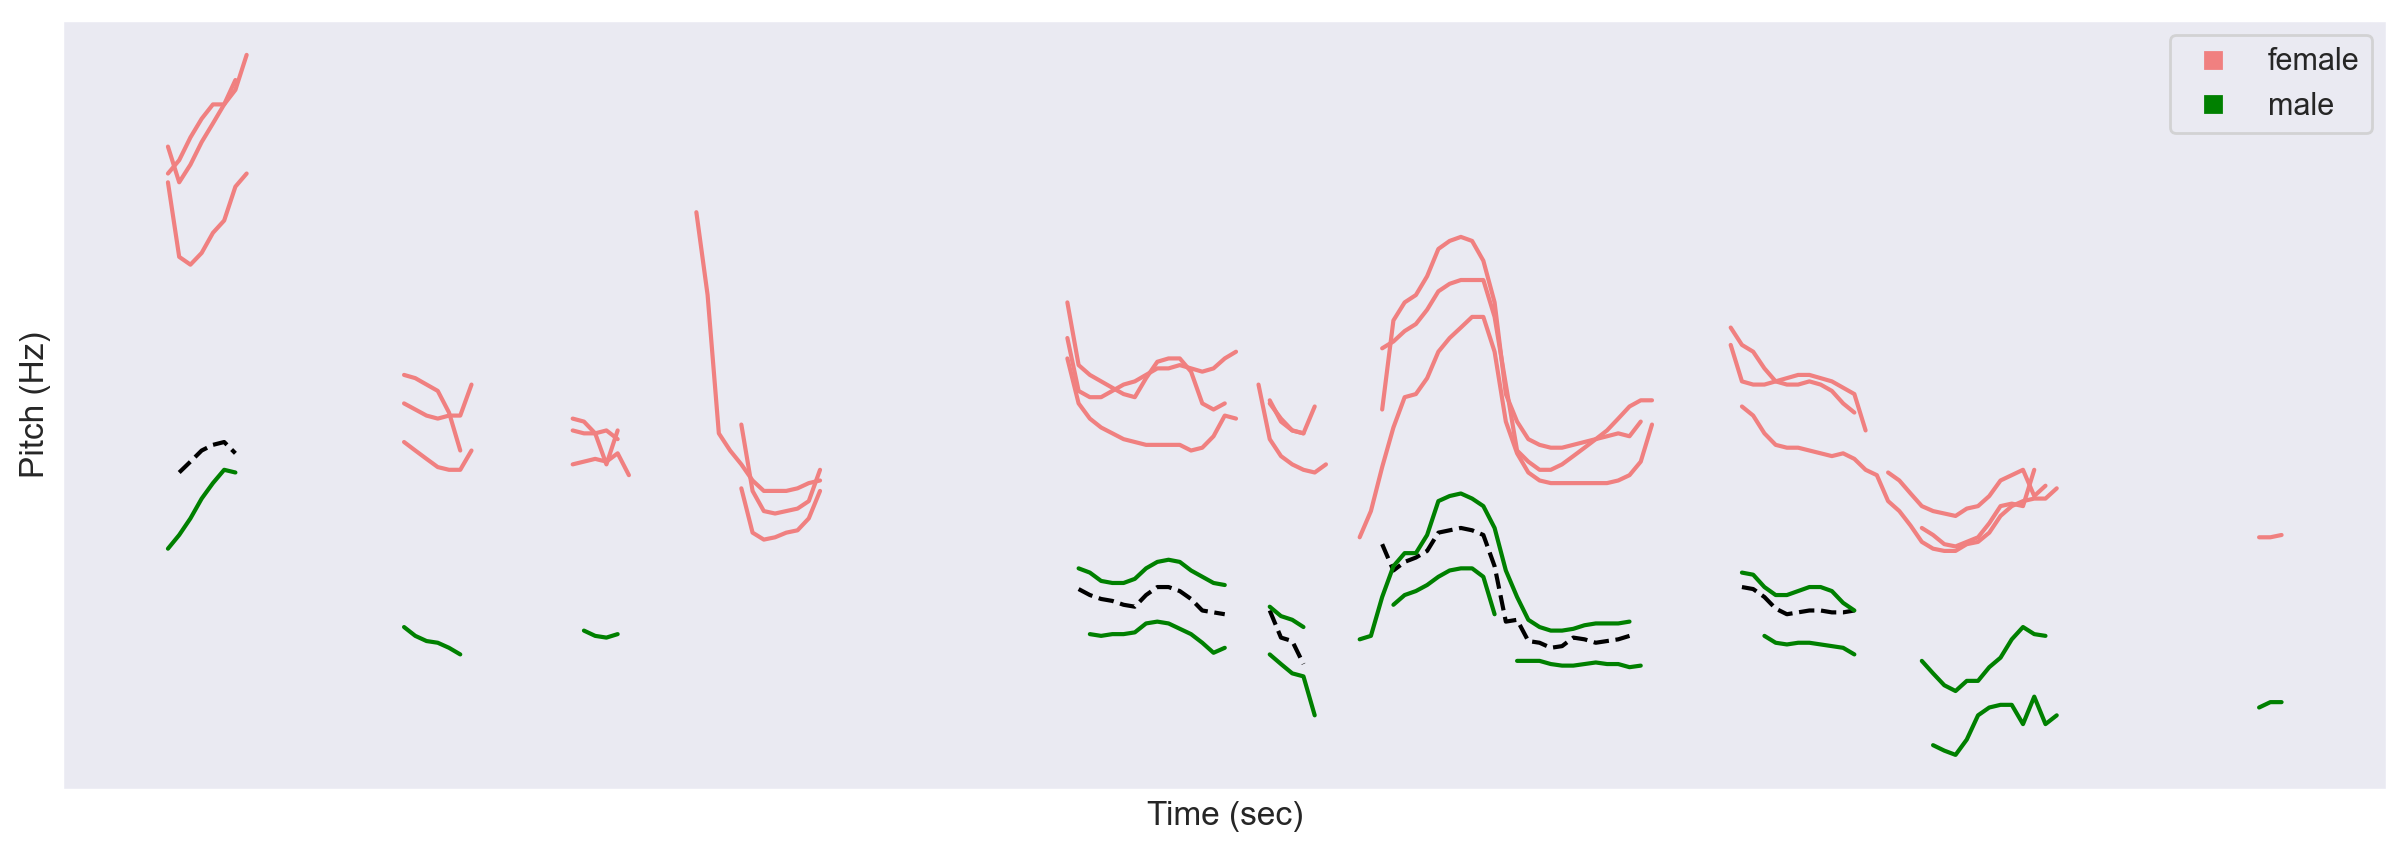

In [13]:
# adjust this to remove noise at the beginning of recording
strt_idx = 50
# adjust this to remove noise at the end of recording
end_idx = -1
plt.figure(figsize=(15, 5))
tf0s, colours, labels, ftimes = get_F0s_for_plots(
    wav_nr, vocoder, target_speakers, f0s)
for idx in range(len(f0s)):
    plt.plot(ftimes[strt_idx:end_idx], tf0s[idx][strt_idx:end_idx],
             color=colours[idx], linestyle='--' if idx == 0 else '-')

get_gender_legend()
plt.xticks([])
plt.yticks([])
plt.xlabel('Time (sec)')
plt.ylabel('Pitch (Hz)')
plt.show()

## Change in Pitch (Speaker)

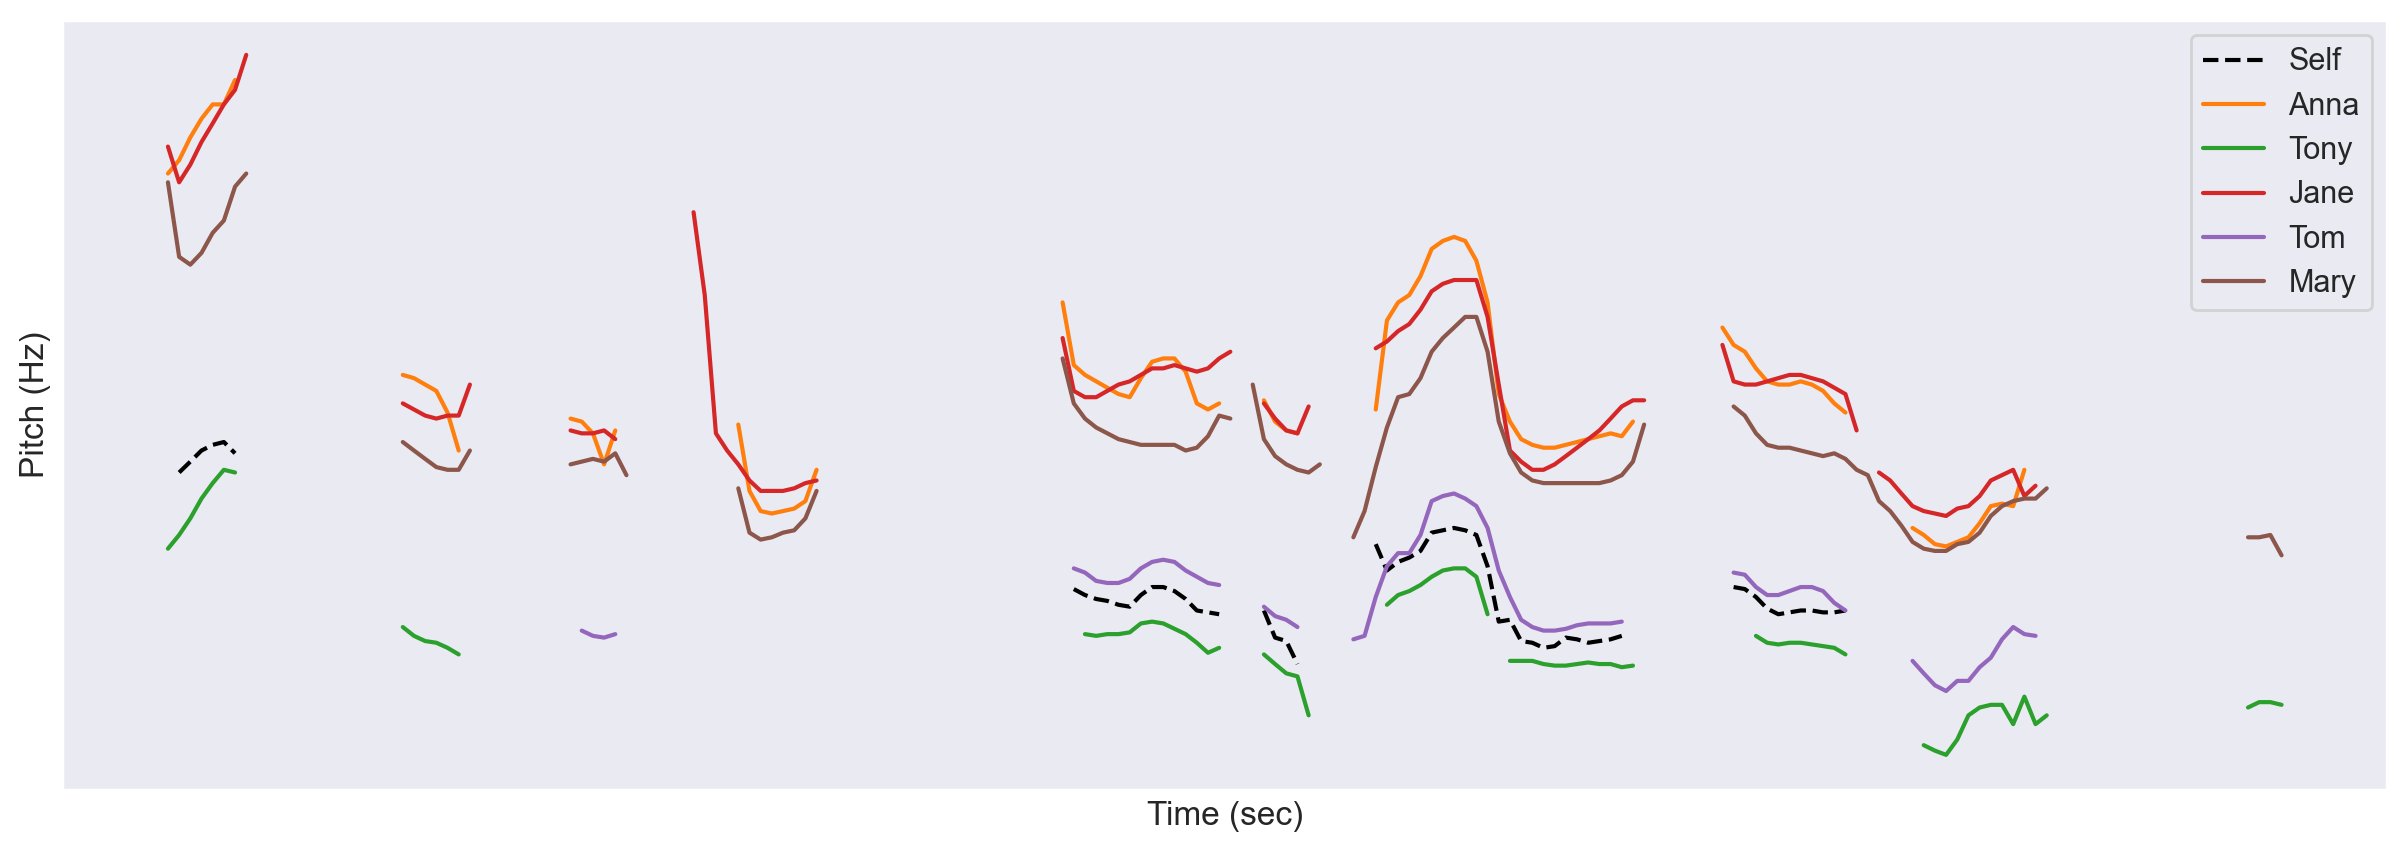

In [14]:
plt.figure(figsize=(15, 5))
for idx in range(len(f0s)):
    plt.plot(ftimes[strt_idx:], tf0s[idx][strt_idx:],
             label='Self' if idx == 0 else labels[idx],
             color='black' if idx == 0 else list(
                 mcolors.TABLEAU_COLORS.values())[idx],
             linestyle='--' if idx == 0 else '-')
plt.xticks([])
plt.yticks([])
plt.xlabel('Time (sec)')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.show()

## Change in Intensity (Gender)

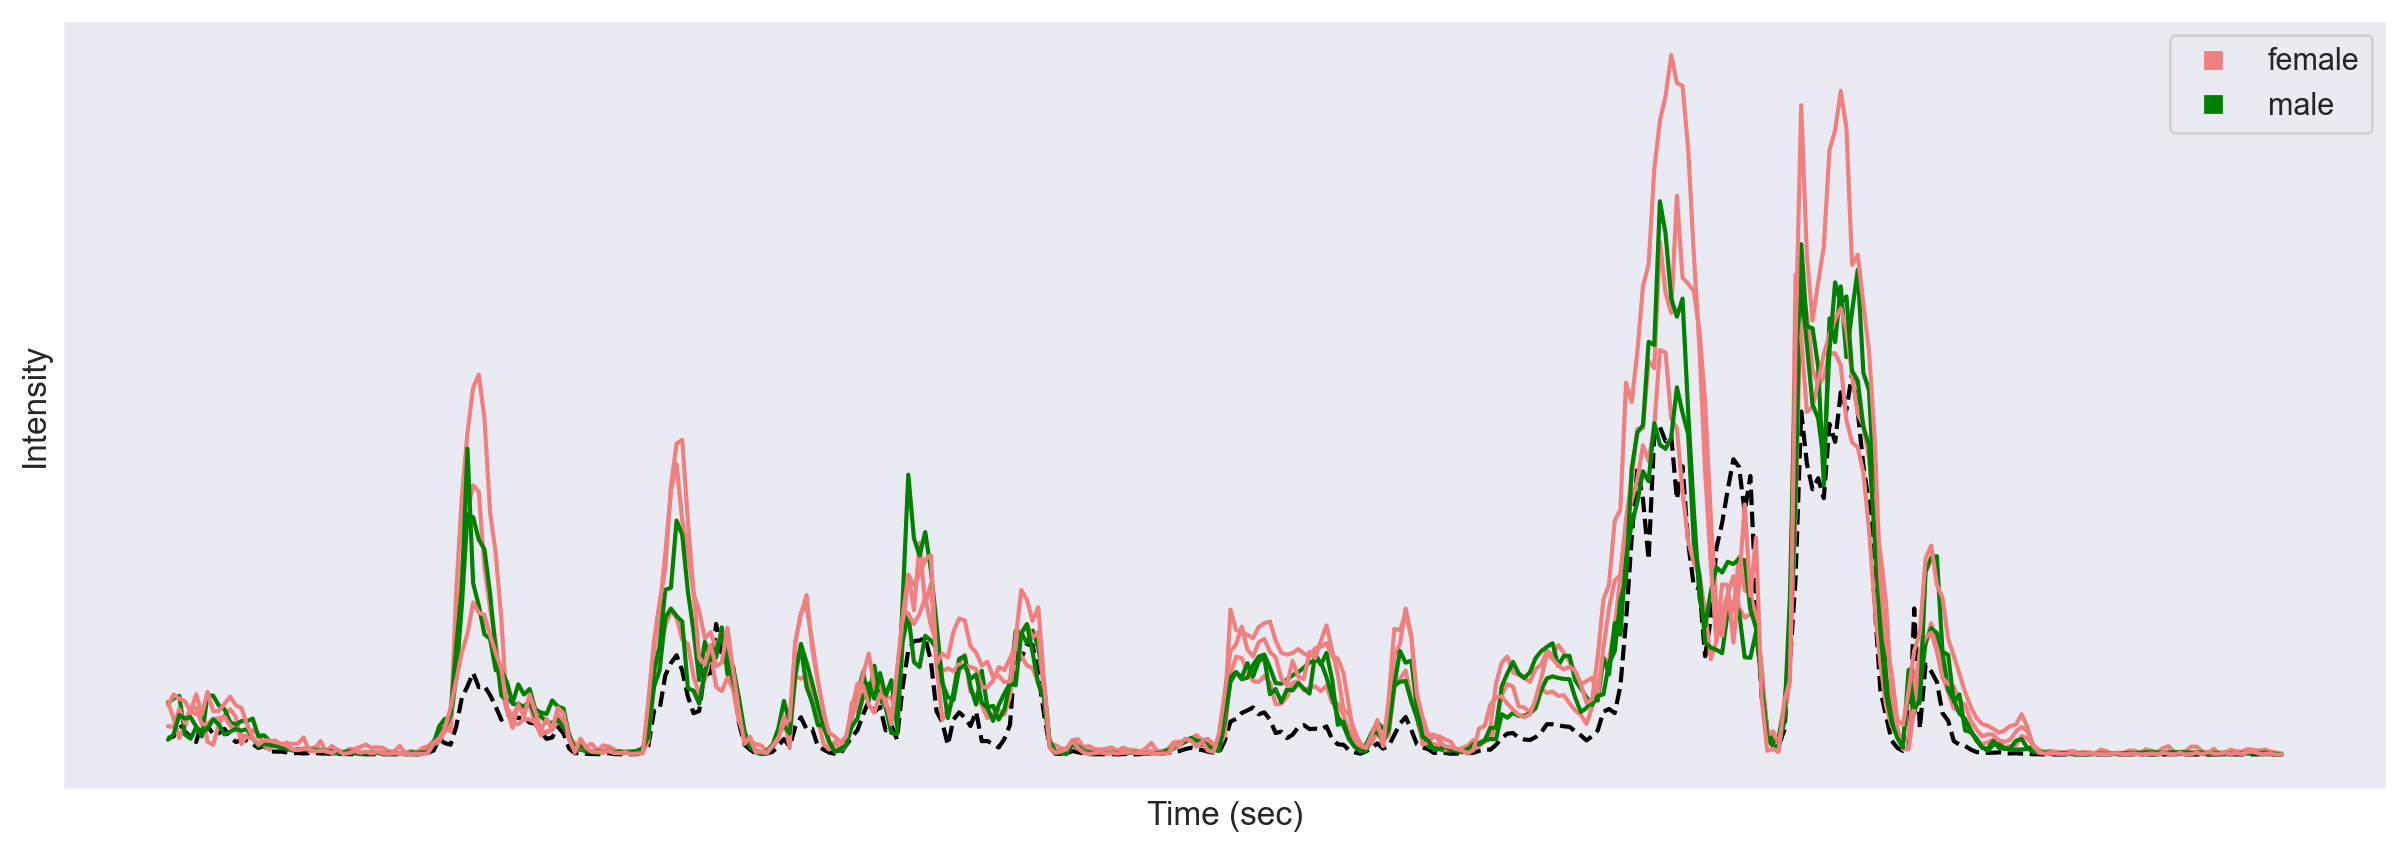

In [15]:
plt.figure(figsize=(15, 5))
intensities, colours, labels, itimes = get_rmse_for_plots(
    wav_nr, vocoder, target_speakers, converted_samples)
for idx in range(len(f0s)):
    plt.plot(itimes[strt_idx:], intensities[idx][strt_idx:],
             color=colours[idx], linestyle='--' if idx == 0 else '-')

get_gender_legend()
plt.xlabel('Time (sec)')
plt.ylabel('Intensity')
plt.xticks([])
plt.yticks([])
plt.show()

## Change in Intensity (Speaker)

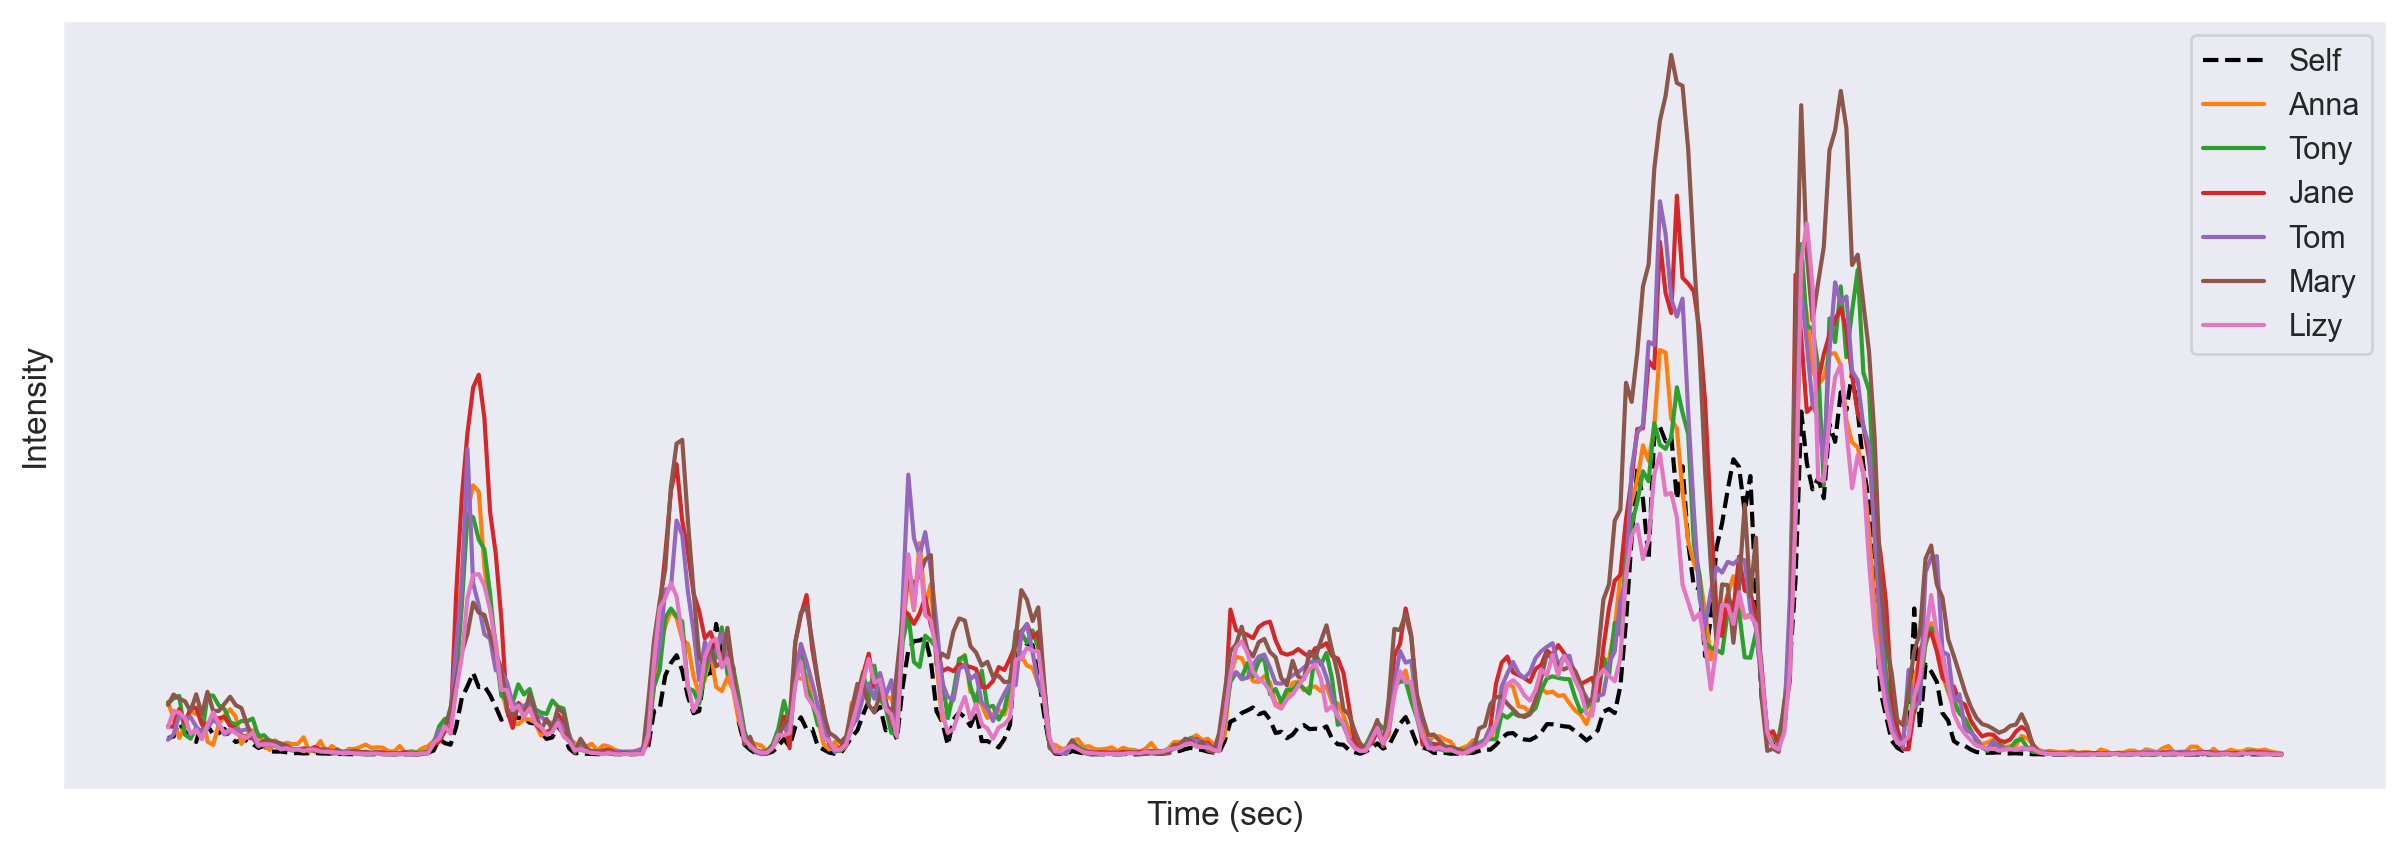

In [16]:
plt.figure(figsize=(15, 5))
for idx in range(len(intensities)):
    plt.plot(itimes[strt_idx:], intensities[idx][strt_idx:],
             label='Self' if idx == 0 else labels[idx],
             color='black' if idx == 0 else list(
                 mcolors.TABLEAU_COLORS.values())[idx],
             linestyle='--' if idx == 0 else '-')
plt.xticks([])
plt.yticks([])
plt.xlabel('Time (sec)')
plt.ylabel('Intensity')
plt.legend()
plt.show()